# Generating Super-Resolution Images

This notebook provides you with a complete code example to increase the resolution of microscopy images using a diffusion model.

## Downloading the BioSR Dataset

In [2]:
import os

if not os.path.exists("biosr_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/biosr_dataset")

Cloning into 'biosr_dataset'...
Updating files: 100% (87902/87902), done.


## Managing the Dataset

In [3]:
import torch
from tifffile import tifffile as tiff

class BioSRDataset(torch.utils.data.Dataset):
    """Dataset class to load the BioSR dataset."""

    def __init__(self, lr_dir, hr_dir, transform):
        """Initialize dataset."""
        self.lr_dir, self.hr_dir, self.transform = lr_dir, hr_dir, transform
        self.file_list = [file for file in os.listdir(self.lr_dir) 
                          if file.endswith(".tif")]

    def __len__(self):
        """Return the number of image pairs."""
        return len(self.file_list)

    def __getitem__(self, index):
        """Get a low-resolution--high-resolution image pair."""
        lr_image = tiff.imread(os.path.join(self.lr_dir, self.file_list[index]))
        hr_image = tiff.imread(os.path.join(self.hr_dir, self.file_list[index]))
        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)
        return lr_image, hr_image

## Preprocessing the Images

In [4]:
from torchvision.transforms import Compose, Normalize, ToTensor

transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

## Creating the Training and Testing Datasets

Create the datasets ...

In [5]:
root = os.path.join("biosr_dataset", "BioSR", "Microtubules")
train_set = BioSRDataset(lr_dir=os.path.join(root, "training_wf"),
                         hr_dir=os.path.join(root, "training_gt"),
                         transform=transform)
test_set = BioSRDataset(lr_dir=os.path.join(root, "test_wf", "level_09"),
                        hr_dir=os.path.join(root, "test_gt"),
                        transform=transform)

... plot some low-resolution and high-resolution images ...

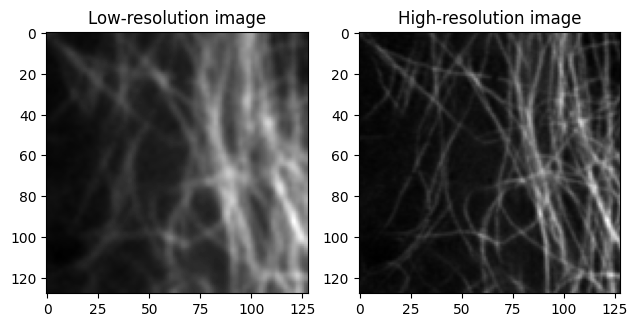

In [6]:
import matplotlib.pyplot as plt
import numpy as np

lr_image, hr_image = train_set[np.random.randint(0, len(train_set))]

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(lr_image.permute(1, 2, 0), cmap="gray")
plt.title("Low-resolution image")

plt.subplot(1, 2, 2)
plt.imshow(hr_image.permute(1, 2, 0), cmap="gray")
plt.title("High-resolution image")

plt.tight_layout()
plt.show()

## Adapting the Diffusion Process for Super-Resolution

Define the device on which the computations are performed ...

In [7]:
import torch

def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [8]:
device = get_device()

In [9]:
print(device)

cuda:0


... implement the reverse diffusion for super-resolution ...

In [10]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28,
                 device=device):
        """Initialize the diffusion model."""
        self.steps, self.img_size, self.device = steps, img_size, device
        self.beta = torch.linspace(beta_start, beta_end, self.steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise
    
    def reverse_diffusion(self, model, n_images, n_channels, pos_enc_dim, 
                          pos_enc_func, input_image, fix_noise=None, 
                          save_time_steps=None):
        """Reverse diffusion process"""
        with torch.no_grad():
            if fix_noise is not None:
                x = fix_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size)
                ).to(self.device)
            
            denoised_images = []
            for i in tqdm(reversed(range(0, self.steps)),
                          desc="U-Net inference", total=self.steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = (pos_enc_func(t.unsqueeze(1), pos_enc_dim)
                             .to(self.device))
                predicted_noise = model(
                    torch.cat((input_image.to(self.device), x), dim=1), 
                    t=t_pos_enc,
                )
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) 
                     / torch.sqrt(1 - alpha_bar)) * predicted_noise) 
                     + torch.sqrt(1-alpha) * noise)
                if i in save_time_steps: denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Defining the Conditional Attention U-Net

In [11]:
import deeplay as dl

pos_enc_dim = 256

unet = dl.AttentionUNet(in_channels=2, channels=[32, 64, 128], 
                        base_channels=[256, 256], 
                        channel_attention=[False, False, False], 
                        out_channels=1, position_embedding_dim=pos_enc_dim)
unet.build()
unet.to(device);

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Training the Conditional Diffusion Model

Define the data loaders ...

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

... instantiate the diffusion class ...

In [13]:
diffusion = Diffusion(steps=2000, img_size=128, beta_start=1e-6, beta_end=0.01)

... define the loss function ...

In [14]:
criterion = torch.nn.L1Loss()

... define the position encoding function ...

In [15]:
def positional_encoding(t, enc_dim):
    """Encode position information with a sinusoid."""
    scaled_positions = torch.arange(0, enc_dim, 2).float() / enc_dim
    frequency = 10000 ** scaled_positions
    inverse_frequency = (1.0 / frequency).to(t.device)
    angle = t.repeat(1, enc_dim // 2) * inverse_frequency
    pos_enc_a, pos_enc_b = torch.sin(angle), torch.cos(angle)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

... define the optimizer ...

In [16]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

... implement the function to prepare the data for super-resolution task ...

In [17]:
def prepare_data(input_image, target_image, steps=2000, device=device):
    """Prepare data."""
    batch_size = input_image.shape[0]
    t = torch.randint(low=0, high=steps, size=(batch_size,)).to(device)
    input_image, target_image = input_image.to(device), target_image.to(device)
    x_t, noise = diffusion.forward_diffusion(target_image, t)
    x_t = torch.cat((input_image, x_t), dim=1)
    t_pos_enc = positional_encoding(t.unsqueeze(1), pos_enc_dim)
    return x_t.to(device), t_pos_enc.to(device), noise.to(device)

... implement the training loop ...


Epoch 1/30
__________
Batch 1/642: Train loss: 0.9253
Batch 101/642: Train loss: 0.1633
Batch 201/642: Train loss: 0.1190
Batch 301/642: Train loss: 0.0781
Batch 401/642: Train loss: 0.0669
Batch 501/642: Train loss: 0.0883
Batch 601/642: Train loss: 0.1139
----------
Epoch 1/30 : Train loss: 0.1343, Time taken: 0:02:54.770605


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.15it/s]


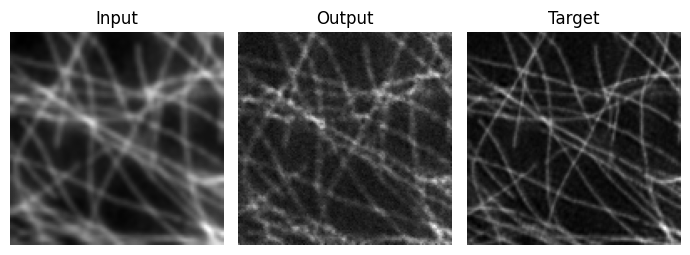


Epoch 2/30
__________
Batch 1/642: Train loss: 0.1028
Batch 101/642: Train loss: 0.0843
Batch 201/642: Train loss: 0.0520
Batch 301/642: Train loss: 0.0658
Batch 401/642: Train loss: 0.0547
Batch 501/642: Train loss: 0.0640
Batch 601/642: Train loss: 0.0703
----------
Epoch 2/30 : Train loss: 0.0708, Time taken: 0:02:52.146367


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.13it/s]


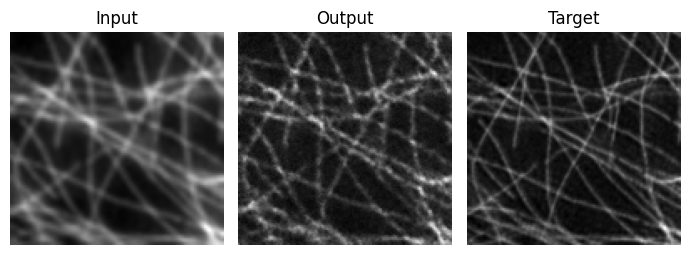


Epoch 3/30
__________
Batch 1/642: Train loss: 0.0730
Batch 101/642: Train loss: 0.0670
Batch 201/642: Train loss: 0.0751
Batch 301/642: Train loss: 0.0846
Batch 401/642: Train loss: 0.0504
Batch 501/642: Train loss: 0.0393
Batch 601/642: Train loss: 0.0560
----------
Epoch 3/30 : Train loss: 0.0635, Time taken: 0:02:51.562571


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 213.24it/s]


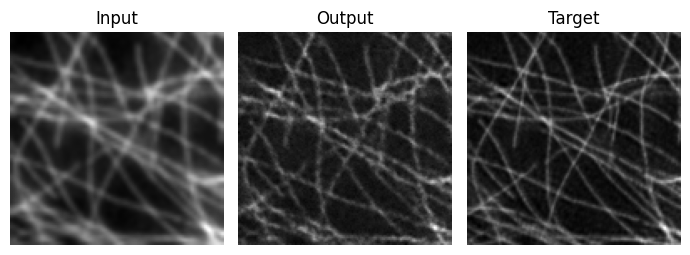


Epoch 4/30
__________
Batch 1/642: Train loss: 0.0503
Batch 101/642: Train loss: 0.0952
Batch 201/642: Train loss: 0.0841
Batch 301/642: Train loss: 0.0490
Batch 401/642: Train loss: 0.0933
Batch 501/642: Train loss: 0.0687
Batch 601/642: Train loss: 0.0852
----------
Epoch 4/30 : Train loss: 0.0606, Time taken: 0:02:51.651015


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 215.21it/s]


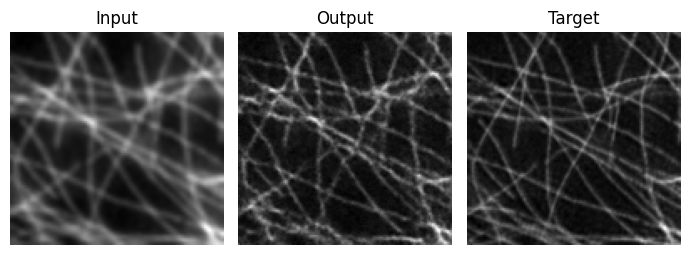


Epoch 5/30
__________
Batch 1/642: Train loss: 0.0582
Batch 101/642: Train loss: 0.0567
Batch 201/642: Train loss: 0.0742
Batch 301/642: Train loss: 0.0523
Batch 401/642: Train loss: 0.0576
Batch 501/642: Train loss: 0.0599
Batch 601/642: Train loss: 0.0531
----------
Epoch 5/30 : Train loss: 0.0571, Time taken: 0:02:51.601639


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 215.64it/s]


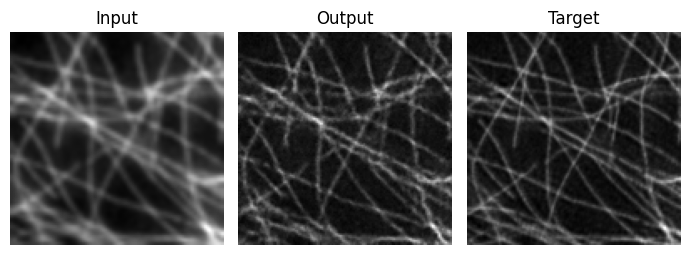


Epoch 6/30
__________
Batch 1/642: Train loss: 0.0472
Batch 101/642: Train loss: 0.0559
Batch 201/642: Train loss: 0.0458
Batch 301/642: Train loss: 0.0603
Batch 401/642: Train loss: 0.0593
Batch 501/642: Train loss: 0.0435
Batch 601/642: Train loss: 0.0336
----------
Epoch 6/30 : Train loss: 0.0554, Time taken: 0:02:51.980161


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 215.40it/s]


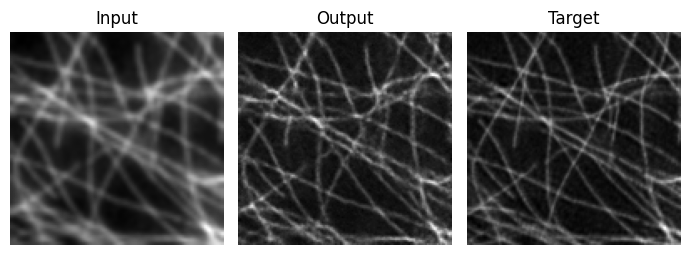


Epoch 7/30
__________
Batch 1/642: Train loss: 0.0523
Batch 101/642: Train loss: 0.0688
Batch 201/642: Train loss: 0.0414
Batch 301/642: Train loss: 0.0256
Batch 401/642: Train loss: 0.0457
Batch 501/642: Train loss: 0.0580
Batch 601/642: Train loss: 0.0531
----------
Epoch 7/30 : Train loss: 0.0539, Time taken: 0:02:51.452123


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 215.28it/s]


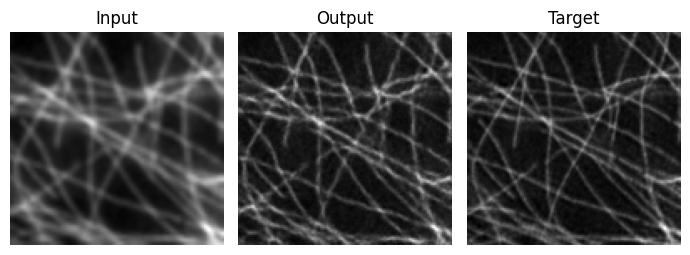


Epoch 8/30
__________
Batch 1/642: Train loss: 0.0447
Batch 101/642: Train loss: 0.0715
Batch 201/642: Train loss: 0.0523
Batch 301/642: Train loss: 0.0741
Batch 401/642: Train loss: 0.0409
Batch 501/642: Train loss: 0.0649
Batch 601/642: Train loss: 0.0535
----------
Epoch 8/30 : Train loss: 0.0536, Time taken: 0:02:51.063658


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.83it/s]


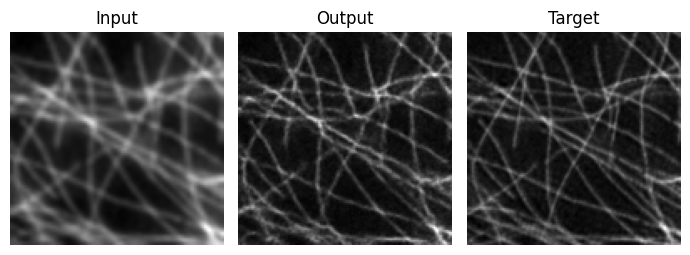


Epoch 9/30
__________
Batch 1/642: Train loss: 0.0493
Batch 101/642: Train loss: 0.0496
Batch 201/642: Train loss: 0.0370
Batch 301/642: Train loss: 0.0782
Batch 401/642: Train loss: 0.0493
Batch 501/642: Train loss: 0.0517
Batch 601/642: Train loss: 0.0657
----------
Epoch 9/30 : Train loss: 0.0529, Time taken: 0:02:51.054828


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.63it/s]


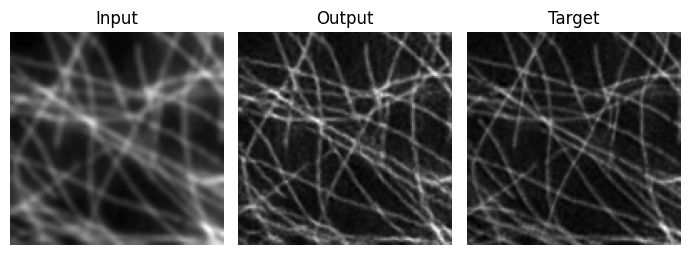


Epoch 10/30
__________
Batch 1/642: Train loss: 0.0556
Batch 101/642: Train loss: 0.0393
Batch 201/642: Train loss: 0.0507
Batch 301/642: Train loss: 0.0697
Batch 401/642: Train loss: 0.0421
Batch 501/642: Train loss: 0.0449
Batch 601/642: Train loss: 0.0501
----------
Epoch 10/30 : Train loss: 0.0521, Time taken: 0:02:51.216675


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 214.01it/s]


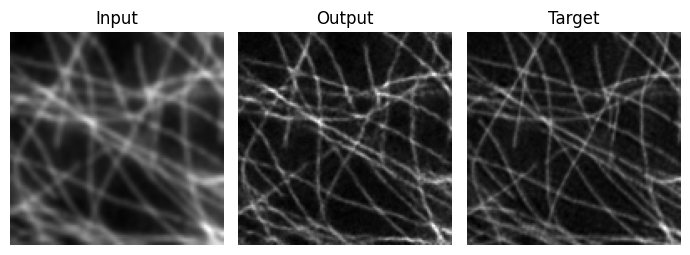


Epoch 11/30
__________
Batch 1/642: Train loss: 0.0811
Batch 101/642: Train loss: 0.0593
Batch 201/642: Train loss: 0.0599
Batch 301/642: Train loss: 0.0471
Batch 401/642: Train loss: 0.0592
Batch 501/642: Train loss: 0.0329
Batch 601/642: Train loss: 0.0510
----------
Epoch 11/30 : Train loss: 0.0514, Time taken: 0:02:51.242847


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 215.03it/s]


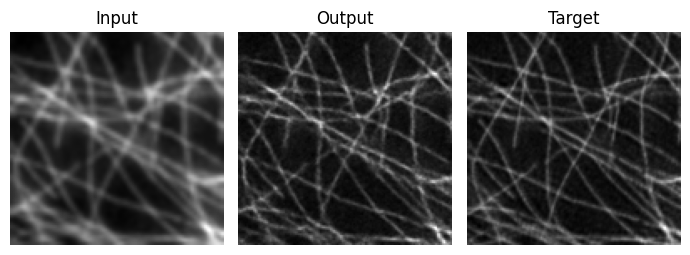


Epoch 12/30
__________
Batch 1/642: Train loss: 0.0434
Batch 101/642: Train loss: 0.0410
Batch 201/642: Train loss: 0.0355
Batch 301/642: Train loss: 0.0522
Batch 401/642: Train loss: 0.0614
Batch 501/642: Train loss: 0.0534
Batch 601/642: Train loss: 0.0293
----------
Epoch 12/30 : Train loss: 0.0502, Time taken: 0:02:51.009657


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.31it/s]


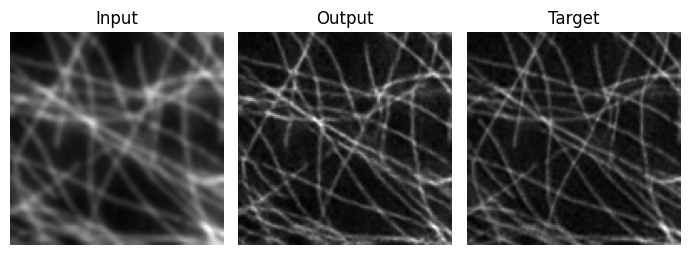


Epoch 13/30
__________
Batch 1/642: Train loss: 0.0491
Batch 101/642: Train loss: 0.0615
Batch 201/642: Train loss: 0.0607
Batch 301/642: Train loss: 0.0389
Batch 401/642: Train loss: 0.0605
Batch 501/642: Train loss: 0.0515
Batch 601/642: Train loss: 0.0730
----------
Epoch 13/30 : Train loss: 0.0499, Time taken: 0:02:51.255637


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.55it/s]


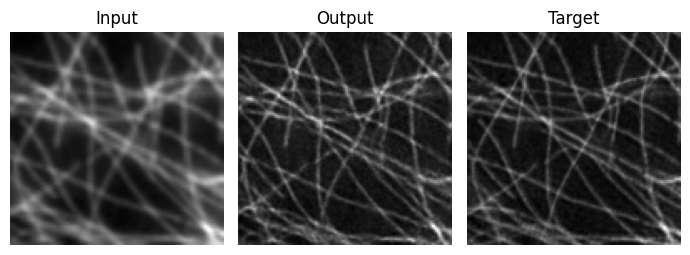


Epoch 14/30
__________
Batch 1/642: Train loss: 0.0596
Batch 101/642: Train loss: 0.0505
Batch 201/642: Train loss: 0.0415
Batch 301/642: Train loss: 0.0520
Batch 401/642: Train loss: 0.0405
Batch 501/642: Train loss: 0.0751
Batch 601/642: Train loss: 0.0328
----------
Epoch 14/30 : Train loss: 0.0499, Time taken: 0:02:51.224847


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 217.04it/s]


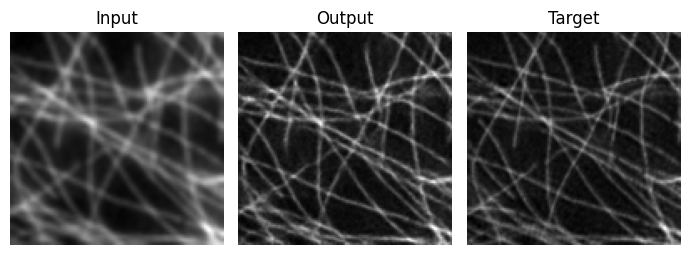


Epoch 15/30
__________
Batch 1/642: Train loss: 0.0562
Batch 101/642: Train loss: 0.0324
Batch 201/642: Train loss: 0.0372
Batch 301/642: Train loss: 0.0531
Batch 401/642: Train loss: 0.0431
Batch 501/642: Train loss: 0.0410
Batch 601/642: Train loss: 0.0395
----------
Epoch 15/30 : Train loss: 0.0489, Time taken: 0:02:51.402513


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 215.18it/s]


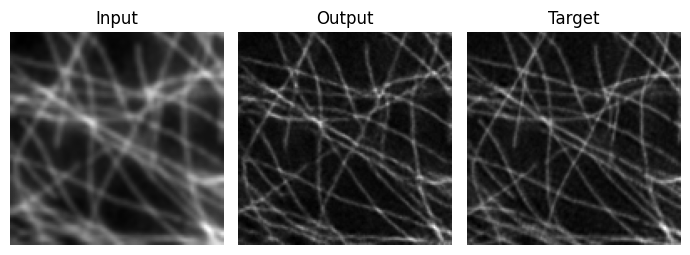


Epoch 16/30
__________
Batch 1/642: Train loss: 0.0495
Batch 101/642: Train loss: 0.0521
Batch 201/642: Train loss: 0.0361
Batch 301/642: Train loss: 0.0493
Batch 401/642: Train loss: 0.0516
Batch 501/642: Train loss: 0.0434
Batch 601/642: Train loss: 0.0446
----------
Epoch 16/30 : Train loss: 0.0484, Time taken: 0:02:51.318333


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.95it/s]


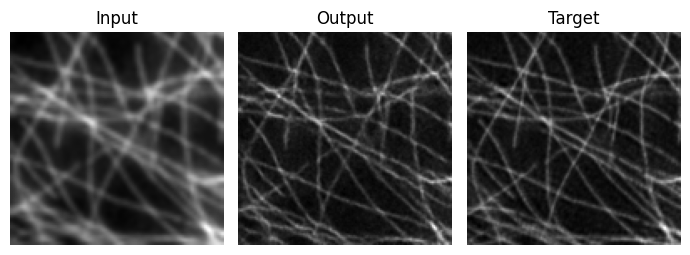


Epoch 17/30
__________
Batch 1/642: Train loss: 0.0585
Batch 101/642: Train loss: 0.0567
Batch 201/642: Train loss: 0.0445
Batch 301/642: Train loss: 0.0607
Batch 401/642: Train loss: 0.0559
Batch 501/642: Train loss: 0.0481
Batch 601/642: Train loss: 0.0356
----------
Epoch 17/30 : Train loss: 0.0483, Time taken: 0:02:51.810649


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.14it/s]


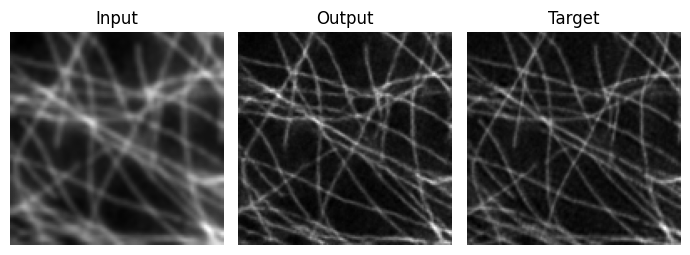


Epoch 18/30
__________
Batch 1/642: Train loss: 0.0466
Batch 101/642: Train loss: 0.0437
Batch 201/642: Train loss: 0.0763
Batch 301/642: Train loss: 0.0471
Batch 401/642: Train loss: 0.0451
Batch 501/642: Train loss: 0.0411
Batch 601/642: Train loss: 0.0318
----------
Epoch 18/30 : Train loss: 0.0489, Time taken: 0:02:52.205955


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 217.20it/s]


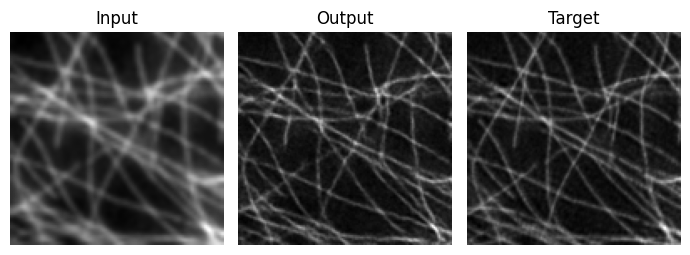


Epoch 19/30
__________
Batch 1/642: Train loss: 0.0654
Batch 101/642: Train loss: 0.0645
Batch 201/642: Train loss: 0.0407
Batch 301/642: Train loss: 0.0335
Batch 401/642: Train loss: 0.0452
Batch 501/642: Train loss: 0.0512
Batch 601/642: Train loss: 0.0639
----------
Epoch 19/30 : Train loss: 0.0480, Time taken: 0:02:51.350201


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 213.75it/s]


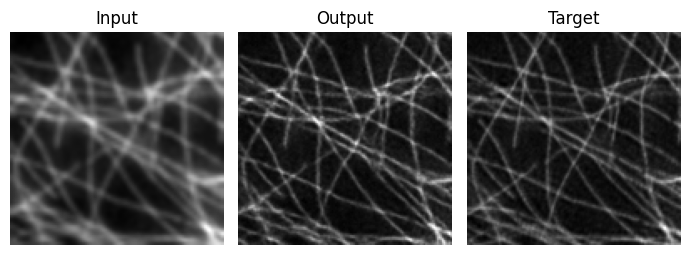


Epoch 20/30
__________
Batch 1/642: Train loss: 0.0628
Batch 101/642: Train loss: 0.0635
Batch 201/642: Train loss: 0.0465
Batch 301/642: Train loss: 0.0425
Batch 401/642: Train loss: 0.0397
Batch 501/642: Train loss: 0.0504
Batch 601/642: Train loss: 0.0500
----------
Epoch 20/30 : Train loss: 0.0474, Time taken: 0:02:51.646924


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 209.04it/s]


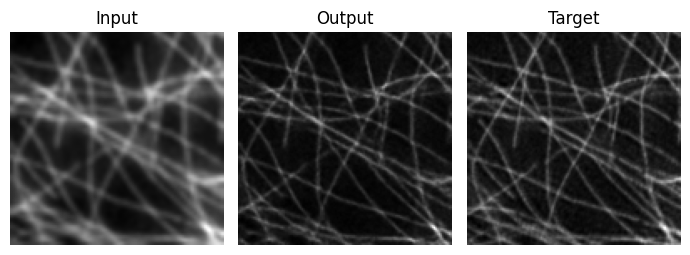


Epoch 21/30
__________
Batch 1/642: Train loss: 0.0319
Batch 101/642: Train loss: 0.0353
Batch 201/642: Train loss: 0.0436
Batch 301/642: Train loss: 0.0582
Batch 401/642: Train loss: 0.0568
Batch 501/642: Train loss: 0.0458
Batch 601/642: Train loss: 0.0480
----------
Epoch 21/30 : Train loss: 0.0466, Time taken: 0:02:52.170554


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 214.92it/s]


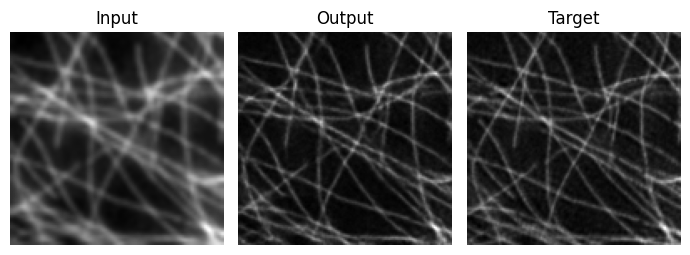


Epoch 22/30
__________
Batch 1/642: Train loss: 0.0484
Batch 101/642: Train loss: 0.0575
Batch 201/642: Train loss: 0.0405
Batch 301/642: Train loss: 0.0441
Batch 401/642: Train loss: 0.0389
Batch 501/642: Train loss: 0.0358
Batch 601/642: Train loss: 0.0564
----------
Epoch 22/30 : Train loss: 0.0466, Time taken: 0:02:51.669670


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 215.63it/s]


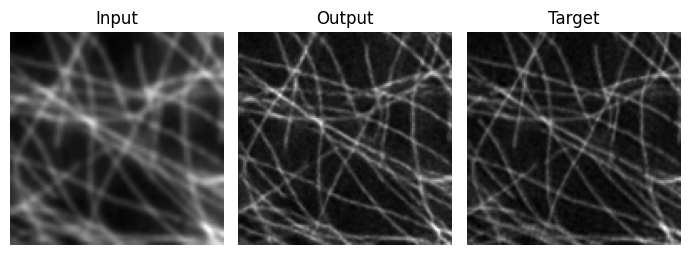


Epoch 23/30
__________
Batch 1/642: Train loss: 0.0396
Batch 101/642: Train loss: 0.0350
Batch 201/642: Train loss: 0.0404
Batch 301/642: Train loss: 0.0467
Batch 401/642: Train loss: 0.0411
Batch 501/642: Train loss: 0.0393
Batch 601/642: Train loss: 0.0424
----------
Epoch 23/30 : Train loss: 0.0464, Time taken: 0:02:51.969541


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 213.56it/s]


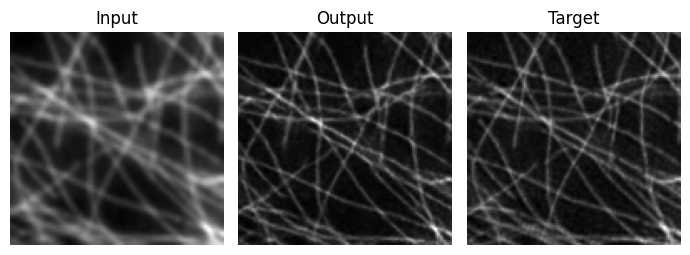


Epoch 24/30
__________
Batch 1/642: Train loss: 0.0681
Batch 101/642: Train loss: 0.0414
Batch 201/642: Train loss: 0.0504
Batch 301/642: Train loss: 0.0316
Batch 401/642: Train loss: 0.0468
Batch 501/642: Train loss: 0.0558
Batch 601/642: Train loss: 0.0458
----------
Epoch 24/30 : Train loss: 0.0466, Time taken: 0:02:51.068408


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.66it/s]


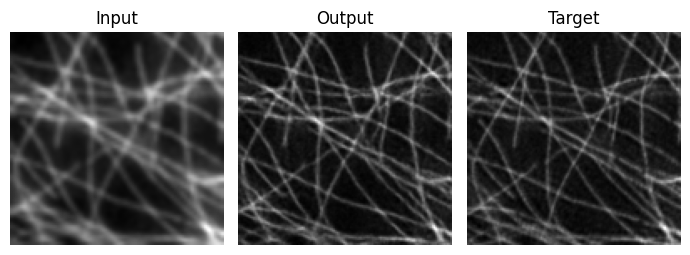


Epoch 25/30
__________
Batch 1/642: Train loss: 0.0435
Batch 101/642: Train loss: 0.0472
Batch 201/642: Train loss: 0.0369
Batch 301/642: Train loss: 0.0372
Batch 401/642: Train loss: 0.0371
Batch 501/642: Train loss: 0.0410
Batch 601/642: Train loss: 0.0361
----------
Epoch 25/30 : Train loss: 0.0467, Time taken: 0:02:51.269521


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 218.19it/s]


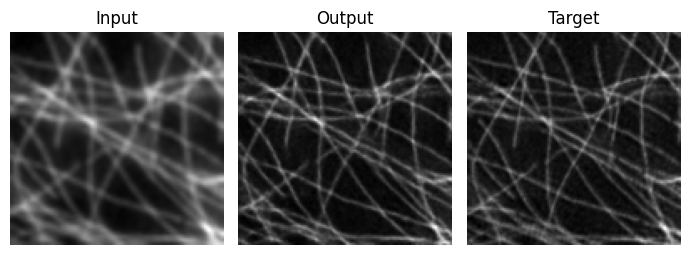


Epoch 26/30
__________
Batch 1/642: Train loss: 0.0361
Batch 101/642: Train loss: 0.0328
Batch 201/642: Train loss: 0.0331
Batch 301/642: Train loss: 0.0445
Batch 401/642: Train loss: 0.0429
Batch 501/642: Train loss: 0.0410
Batch 601/642: Train loss: 0.0432
----------
Epoch 26/30 : Train loss: 0.0468, Time taken: 0:02:51.047177


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 217.38it/s]


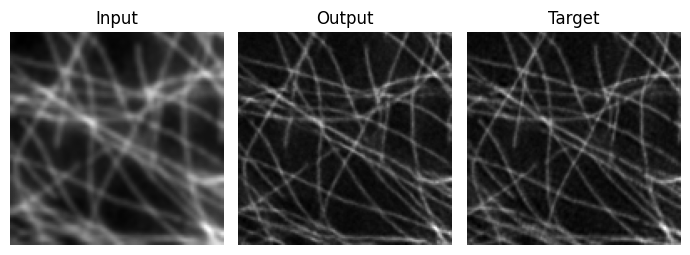


Epoch 27/30
__________
Batch 1/642: Train loss: 0.0452
Batch 101/642: Train loss: 0.0538
Batch 201/642: Train loss: 0.0561
Batch 301/642: Train loss: 0.0435
Batch 401/642: Train loss: 0.0334
Batch 501/642: Train loss: 0.0461
Batch 601/642: Train loss: 0.0696
----------
Epoch 27/30 : Train loss: 0.0464, Time taken: 0:02:51.142034


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 215.31it/s]


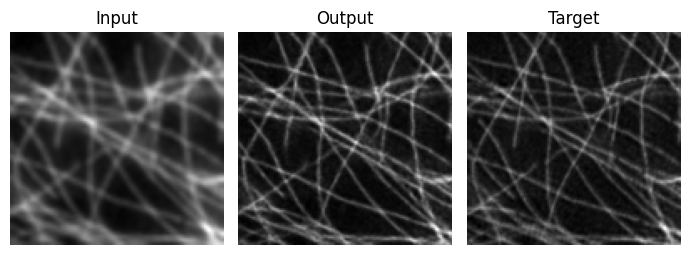


Epoch 28/30
__________
Batch 1/642: Train loss: 0.0319
Batch 101/642: Train loss: 0.0648
Batch 201/642: Train loss: 0.0446
Batch 301/642: Train loss: 0.0592
Batch 401/642: Train loss: 0.0370
Batch 501/642: Train loss: 0.0495
Batch 601/642: Train loss: 0.0439
----------
Epoch 28/30 : Train loss: 0.0465, Time taken: 0:02:51.390270


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 214.22it/s]


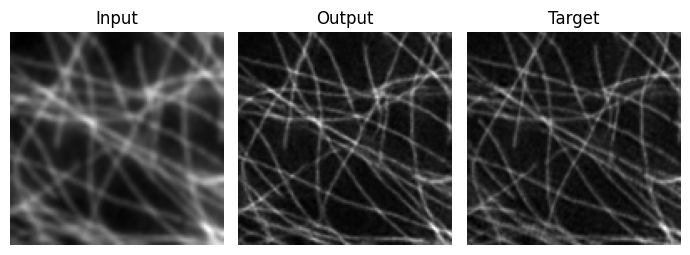


Epoch 29/30
__________
Batch 1/642: Train loss: 0.0524
Batch 101/642: Train loss: 0.0342
Batch 201/642: Train loss: 0.0454
Batch 301/642: Train loss: 0.0299
Batch 401/642: Train loss: 0.0412
Batch 501/642: Train loss: 0.0546
Batch 601/642: Train loss: 0.0602
----------
Epoch 29/30 : Train loss: 0.0458, Time taken: 0:02:51.093996


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 216.93it/s]


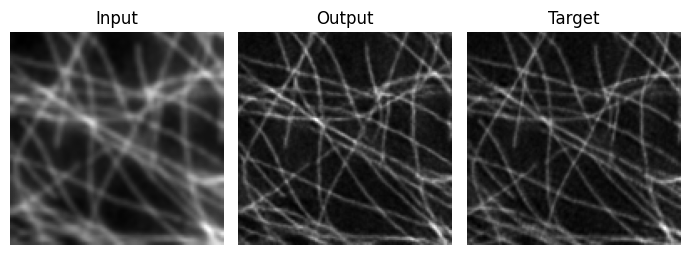


Epoch 30/30
__________
Batch 1/642: Train loss: 0.0485
Batch 101/642: Train loss: 0.0457
Batch 201/642: Train loss: 0.0364
Batch 301/642: Train loss: 0.0621
Batch 401/642: Train loss: 0.0316
Batch 501/642: Train loss: 0.0414
Batch 601/642: Train loss: 0.0587
----------
Epoch 30/30 : Train loss: 0.0461, Time taken: 0:02:50.725033


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 218.74it/s]


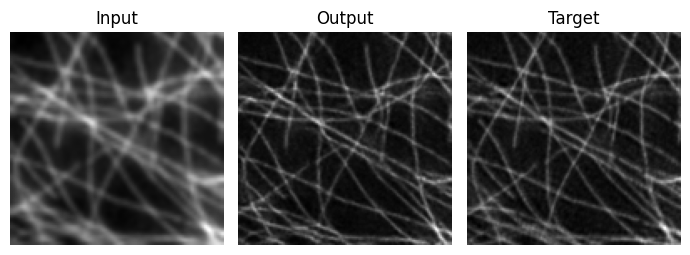

In [18]:
import time
from datetime import timedelta

epochs = 30

train_loss = []
for epoch in range(epochs):
    unet.train()
    
    start_time = time.time()
    num_batches = len(train_loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
    
    running_loss = 0.0
    for batch_idx, (input_images, target_images) in enumerate(train_loader, start=0):
        x_t, t_pos_enc, noise = prepare_data(input_images, target_images)
        
        outputs = unet(x=x_t, t=t_pos_enc)

        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(train_loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Train loss: {train_loss[-1]:.4f}, " 
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    unet.eval()
    for test_input_images, test_target_images in test_loader:
        generated_images = diffusion.reverse_diffusion(
            model=unet, n_images=1, n_channels=1, 
            pos_enc_dim=pos_enc_dim, pos_enc_func=positional_encoding, 
            input_image=test_input_images[:1], save_time_steps=[0],
        )
        break

    lr_image = test_input_images[0]
    image_diff_traj = generated_images[0]
    hr_generated_image = image_diff_traj[-1]
    target_image = test_target_images[0]

    fig = plt.figure(figsize=(7, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_image.permute(1, 2, 0), cmap="gray")
    plt.title("Input")
    plt.axis("off") 
    
    plt.subplot(1, 3, 2)
    plt.imshow(hr_generated_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.title("Output")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(target_image.permute(1, 2, 0), cmap="gray")
    plt.title("Target")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()

...Plot the training loss...

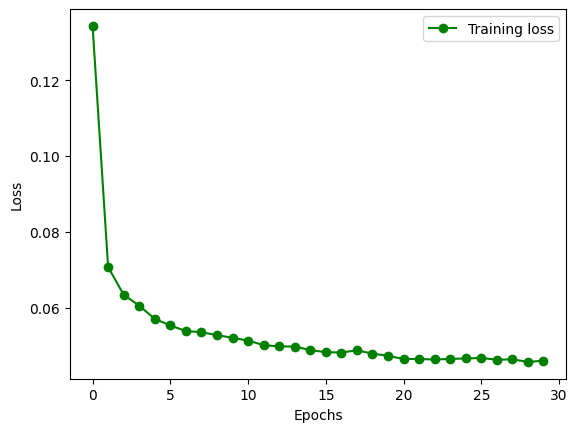

In [19]:
plt.figure()
plt.plot(train_loss, "g-o", label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()